In [127]:
import numpy as np
import matplotlib.pyplot as plt

In [128]:
import os
import shutil
import time

# Plot Space average of u(t)

In [129]:
dt = 0.01
tspan = 110
tspan/dt

11000.0

In [130]:
dx = 1
L = 100
R0 = 25

In [131]:
title = "2D NORMAL Circular island\n$C = 1 + 0.1 \sin(2pi t/T)$ $T=25$\ndt = " + str(dt) + " dx = " + str(dx)

# Motion by curvature
As the border is circular, here we check motion by curvature ($v=-\kappa$) by checking the relation
$$R^2 = 2(t_{coll} - t)$$
where $t_{coll}$ is the time when the island collapses to $R=0$.

It is simpler to check this relation instead of calculating $dv/dt$ and $1/\kappa$.

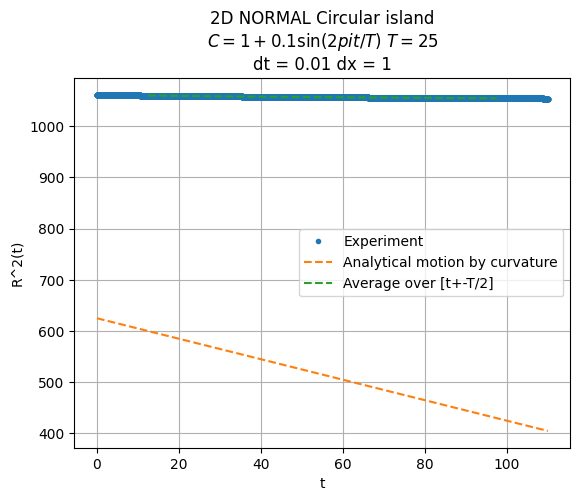

In [132]:
f = open("../fileAveout.dat", "r")
N = int(round(tspan/dt))
tt = np.zeros(N)
ave = np.zeros(N)

i = 0
for row in f:
    a, b = row.split(" ")
    tt[i] = float(a)
    ave[i] = float(b)
    #print(ave[i])
    i = i + 1

if(N-i != 0):
    print("WARNING: dt or tspan is incorrect!")

# Calculate the radius (by exploiting tanh, and we expect even corrections to it, are ODD in (r-R))
area = (ave+np.ones(N))*L**2/2
r2 = np.zeros(len(area))                # Radius squared R^2
for i in np.arange(0, len(area)):
    r2[i] = area[i]/np.pi
    #print(str(area[i]) + " " + str(i))

# Times to plot
ts = np.arange(0, tt[len(tt)-1], dt)
ns = np.arange(0, len(ts))
for i in np.arange(0,len(ns)):
    ns[i] = int(ts[i]/dt)
#ts = np.arange(0, i, int(T/dt))

# Motion by curvature
fig, ax = plt.subplots()
ax.plot(tt[ns], r2[ns],'.', label="Experiment")
ax.set_xlabel("t")
ax.set_ylabel("R^2(t)")
ax.grid()
ax.set_title(title)

# Analytical expected result
r2_anal = R0*R0*np.ones(len(r2)) - 2*tt
ax.plot(tt[ns], r2_anal[ns], "--", label="Analytical motion by curvature")

# Calculate the average over a period
T = 25
nT = int(T/dt)  # Number of steps corresponding to a period
r2ave = np.zeros(len(r2)-nT)
nsave = np.arange(0,len(tt)-nT)
for i in np.arange(0, len(r2)):
    if i >= nT:
        r2ave[i-nT] = np.average(r2[ns[i-nT]:ns[i]])
        nsave[i-nT] = ns[int(i-nT/2)]
ax.plot(tt[nsave], r2ave, "--", label="Average over [t+-T/2]")


ax.legend()
t_min = 40
t_max = t_min + 2/25
#ax.set_xlim(t_min,t_max)
#ax.set_ylim(544,548)

In [133]:
r2[ns[0]]

1061.0114836377854

# Plot final state u(x, tmax)

/tmp/ipykernel_11529/1122534620.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.get_cmap('Blues'), vmin=-1, vmax=1)


Text(0.5, 1.0, 't = 110.000000')

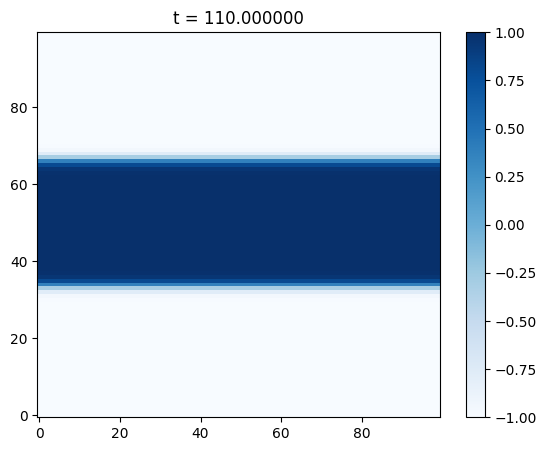

In [134]:
f = open("../state.dat", "r")
N = int(L/dx)
x = np.zeros(N)
y = np.zeros(N)
Z = np.zeros((N,N))
i = 0
for row in f:
    if i != 0:
        a, b, c = row.split(" ")
        #a, b = row.split("	")
        J = np.mod(i-1,N)
        I = int((i-1)/N)
        x[I] = float(a)
        y[J] = float(b)
        Z[I][J] = float(c)
    else:
        N, tmax, dx = row.split(" ")
        dx = float(dx)
        N = int(N)

    i = i + 1

#x = x[0:i-1]
#y = y[0:i-1]

# Make up some fake data
X,Y = np.meshgrid(x,y)

fig = plt.figure(figsize = (6.5,5))
fig.subplots_adjust(wspace=0.3)

# Blues
#plt.figure(figsize=(10,10))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.get_cmap('Blues'), vmin=-1, vmax=1)
plt.colorbar()
#plt.axis([-3, 3, -3, 3])
plt.title('t = ' + str(tmax))